## ChatBot setup

In [1]:
# %pip install openai
# %pip install evaluate
# %pip install py-readability-metrics
# %pip install sacrebleu
# %pip install sacremoses
# %pip install nltk
# %pip install textstat

In [2]:
import openai
import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
import pprint

# NLP packages
import evaluate
import readability
import nltk
import textstat

In [3]:
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Matas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
openai_api_key = ""
openai_model = "gpt-4o-mini"

In [5]:
class ChatBot:
    def __init__(self, model, api_key):
        self.client = openai.OpenAI(api_key=api_key)
        self.model = model
        self.chat_log = []

    def add_system_prompt(self, prompt):
        self.chat_log.append({"role": "system", "content": prompt})
    
    def send_prompt(self, prompt):
        self.chat_log.append({"role": "user", "content": prompt}) 
        response = self.client.chat.completions.create(
            model=self.model,
            messages=self.chat_log
        )
        self.chat_log.append({"role": "assistant", "content": response.choices[0].message.content})

    def get_last_response(self):
        return self.chat_log[-1]["content"]
    
    def print_chat(self):
        for message in self.chat_log:
            print(f"{message["role"].upper()}: {message["content"]}", end="\n\n")

    def save_chat(self):
        current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
        file_name = f"./runs/chat-log_{current_datetime}.json"
        with open(file_name, "w") as file:
            json.dump(self.chat_log, file)

    def clear_chat(self):
        self.chat_log = []

In [6]:
# # chat_bot = ChatBot(
# #     model="gpt-4o-mini",
# #     api_key=api_key,
# # )

# temp_bot = ChatBot(
#     model="gpt-4o-mini",
#     api_key=api_key,
# )
# temp_bot.add_system_prompt("You solve math equations")
# temp_bot.send_prompt("What is 2+3?")
# temp_bot.print_chat()

In [7]:
algorithm_results = {}

## Evaluation

#### Dataset

In [8]:
# Rewrite to class?

dataset = {}

for data_type in ["train", "test"]:
    dataset[data_type] = {}
    for passage_length in ["abs", "snt"]:
        dataset[data_type][passage_length] = {}

for data_type in ["train", "test"]:
    for passage_length in ["abs", "snt"]:
        for passage_type in ["source", "reference"]:
            if data_type == "test" and passage_type == "reference":
                continue
                
            folder = f"./dataset/{data_type}/"
            file_name = f"simpletext_task3_2024_{data_type}_{passage_length}_{passage_type}.json"
            path = folder + file_name

            print("Reading: " + path)
            with open(path, "r", encoding="utf8") as file:
                data = json.load(file)
            
            dataset[data_type][passage_length][passage_type] = data

Reading: ./dataset/train/simpletext_task3_2024_train_abs_source.json
Reading: ./dataset/train/simpletext_task3_2024_train_abs_reference.json
Reading: ./dataset/train/simpletext_task3_2024_train_snt_source.json
Reading: ./dataset/train/simpletext_task3_2024_train_snt_reference.json
Reading: ./dataset/test/simpletext_task3_2024_test_abs_source.json
Reading: ./dataset/test/simpletext_task3_2024_test_snt_source.json


#### Metrics

Mssing metrics:
- count
- Compression ratio
- Sentence splits
- Levenshtein similarity
- Exact copies
- Additions proportion
- Deletions proportion
- Lexical complexity score

In [9]:
bleu = evaluate.load("bleu")
sari = evaluate.load("sari")

In [10]:
def compute_metrics(sources, predictions, references):
    # sources – original passages, predictions – simplified passages, references – target simplifications
    sari_nested_references = [[reference] for reference in references]
    
    results = {}
    results["SARI"] = sari.compute(sources=sources, predictions=predictions, references=sari_nested_references)["sari"]
    results["BLEU"] = bleu.compute(predictions=predictions, references=references)["bleu"]
    # results["FKGL"] = readability.Readability(simplified_passage).flesch_kincaid() # Should I use score or grade.level?
    results["FKGL"] = np.mean([textstat.flesch_kincaid_grade(passage) for passage in predictions])

    return results

In [11]:
# >>> predictions = ["hello there general kenobi", "foo bar foobar"]
# >>> references = [
# ...     ["hello there general kenobi", "hello there !"],
# ...     ["foo bar foobar"]
# ... ]
# >>> bleu = evaluate.load("bleu")
# >>> results = bleu.compute(predictions=predictions, references=references)

In [12]:
# sources=["About 95 species are currently accepted."]
# predictions=["About 95 you now get in."]
# references=[["About 95 species are currently known.","About 95 species are now accepted.","95 species are now accepted."]]
# sari_score = sari.compute(sources=sources, predictions=predictions, references=references)

## Algorithm

In [13]:
algorithm_parameters = {
    "DC": "University student",
    "ILT": "Medium"
}

In [14]:
system_prompt = """
You are a reader assistant. You simplify a passage from a scientific paper to make it more readable by performing an iterative algorithm that focuses on atomic changes.

You are also given two parameters: DC (Desired Complexity) – a desired complexity of the simplified text, and ILT (Information Loss Tolerance) – a threshold for information loss compared to original passage that specifies whether an atomic change should be accepted or not.

The algorithm is as follows:
1. Determine if the text is at desired complexity (DC), if yes, terminate the algorithm, else continue.
2. Identify a section of the text whose complexity is above DC.
3. Propose a simplification of the identified section.
4. Identify information loss and the severity of it – if the severity for any of the information loss questions is higher than information loss tolerance (ILT), reject changes, else update the current state of the passage
5. Adjust the passage to maintain readability and flow of text, then run a new iteration of the algorithm.

When the algorithm terminates, you print the final simplified passage
"""

In [15]:
non_iterative_system_prompt = """
You are a reader assistant. You simplify a passage from a scientific paper to make it more readable.

You are also given two parameters: DC (Desired Complexity) – a desired complexity of the simplified text, and ILT (Information Loss Tolerance) – a threshold for information loss compared to original passage.

Only print the simplified passage
"""

In [16]:
aiir_mistral_system_prompt = """
You are a skilled editor, known for your ability to simplify complex text while preserving it. You explain the technical terms, defining what they are (e.g., terms like Blockchain, Cryptojacking, all abbreviations), without removing sentences or summarizing them.
"""

aiir_llama_run_1_system_prompt = """
Simplify this text for English speaking science students in college. Maximize the use of simple words and short sentences, but include keywords from the original text. Optimize the output ROUGE, SARI, and BLEU scores
"""

In [29]:
def simplify_passage_iteratively(chat_bot, system_prompt, parameters, passage, max_iter=20):
    chat_bot.clear_chat()
    
    chat_bot.add_system_prompt(system_prompt)
    chat_bot.add_system_prompt(f"The passage:\n{passage}")

    if parameters is not None and parameters != {}:
        chat_bot.add_system_prompt("\n".join(f"{parameter}: {value}" for parameter, value in parameters.items()))

    for _ in range(max_iter):
        chat_bot.send_prompt("Identify which parts of the text are the most complex, then the complexity level of the passage")
        chat_bot.send_prompt(f'Is determined complexity higher than DC ({algorithm_parameters["DC"]})? Answer "Yes" or "No"')
        if "NO" in chat_bot.get_last_response().upper():
            break
        chat_bot.send_prompt(f'Identify a single complicated section of the passage. Remember to respect the ILT ({algorithm_parameters["ILT"]}) contraint. Only provide the identified section')
        chat_bot.send_prompt("Simplify this section. Only provide the proposed simplification")
        chat_bot.send_prompt("Reincorporate the simplified section into the passage")
        chat_bot.send_prompt("Identify information loss and its severity in the updated passage compared to the original. Comparison must be between the originally provided (the very first) passage and the current simplified version")
        chat_bot.send_prompt(f'What is the highest severity level identified in your last answer? Is it higher than ILT ({algorithm_parameters["ILT"]})? Provide the highest severity level, followed by an answer to the ILT question as "Yes" or "No"')
        if "YES" in chat_bot.get_last_response().upper():
            chat_bot.send_prompt("Revert the last proposed change. In further iterations you may still attempt to simplify this section in other ways")
        # else:
        #     chat_bot.send_prompt("If needed, adjust the passage to maintain readabily and flow of text")

    chat_bot.send_prompt("Print the final version of the simplified passage, include only the text of the passage with no comments or additional punctuation, and do not provide the original passage")
    # chat_bot.print_chat()
    chat_bot.save_chat()

    return chat_bot.get_last_response()

In [30]:
def get_sources_and_references(passage_type_abbreviation, n):    
    sources = [entry[f"source_{passage_type_abbreviation}"] for entry in dataset["train"][passage_type_abbreviation]["source"][:n] ]
    references = [entry[f"simplified_{passage_type_abbreviation}"] for entry in dataset["train"][passage_type_abbreviation]["reference"][:n] ]

    return (sources, references)

In [31]:
def simplify_passages(algorithm_fn, system_prompt, parameters, passage_type, max_iter, n=None):
    if passage_type == "abstract":
        sources, references = get_sources_and_references("abs", n)
    elif passage_type == "sentence":
        sources, references = get_sources_and_references("snt", n)
    else:
        raise ValueError('Passage type should be "abstract" or "sentence"')

    predictions = []
    results = []
    
    for i in range(len(sources)):
        chat_bot = ChatBot(
            model=openai_model,
            api_key=api_key,
        )

        prediction = algorithm_fn(chat_bot, system_prompt, parameters, sources[i], max_iter)
        # metrics = compute_metrics([sources[i]], [prediction], [references[i]])

        predictions.append(prediction)
        results.append({
            "source": sources[i],
            "prediction": prediction,
            "reference": references[i],
            # "metrics": metrics,
        })

    overall_metrics = compute_metrics(sources, predictions, references)
    return (overall_metrics, results)

In [32]:
passages_to_simplify = 1
passage_type_to_simplify = "sentence"

algorithm_results["iterative"] = simplify_passages(simplify_passage_iteratively, system_prompt, algorithm_parameters, passage_type_to_simplify, 20, passages_to_simplify)
# algorithm_results["non_iterative"] = simplify_passages(simplify_passage_iteratively, non_iterative_system_prompt, algorithm_parameters, passage_type_to_simplify, 0, passages_to_simplify)
# algorithm_results["aiir_mistral_prompt"] = simplify_passages(simplify_passage_iteratively, aiir_mistral_system_prompt, {}, passage_type_to_simplify, 0, passages_to_simplify)
# algorithm_results["aiir_llama_run_1_prompt"] = simplify_passages(simplify_passage_iteratively, aiir_llama_run_1_system_prompt, {}, passage_type_to_simplify, 0, passages_to_simplify)

In [27]:
print("METRICS:")
for algorithm, results in algorithm_results.items():
    print(f"{algorithm.upper()}: {results[0]}")

METRICS:
ITERATIVE: {'SARI': 28.9918552530897, 'BLEU': 0.038220874585128115, 'FKGL': 12.66}


In [28]:
print("SIMPLIFICATION EXAMPLES:")
print(200*"–")
for i in range(5):
    print(f"{i}:")
    print(f"SOURCE: {algorithm_results["iterative"][1][i]["source"]}")
    print(f"REFERENCE: {algorithm_results["iterative"][1][i]["reference"]}")
    for algorithm, results in algorithm_results.items():
        print(f"{algorithm.upper()}:")
        print(results[1][i]["prediction"])
    print(200*"–")
    print()

SIMPLIFICATION EXAMPLES:
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
0:
SOURCE: In the modern era of automation and robotics, autonomous vehicles are currently the focus of academic and industrial research.
REFERENCE: Current academic and industrial research is interested in autonomous vehicles.
ITERATIVE:
In today's world of automation and robots, self-driving cars are currently the focus of school and industry studies
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

1:
SOURCE: With the ever increasing number of unmanned aerial vehicles getting involved in activities in the civilian and commercial domain, there is an increased need for autonomy in these systems too.
REFERENCE: Dro

In [32]:
# current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
# with open(f"./evaluations/{passage_type_to_simplify}s_university_medium_max20_{current_datetime}", "w") as file:
#     json.dump(algorithm_results, file)

## Playground

In [54]:
with open('evaluations/abstracts_university_medium_max20_2024-12-12_21-37-41.106794') as f:
    old_simplifications = json.load(f)

In [96]:
old_fkgl_scores = np.array([(textstat.flesch_kincaid_grade(passage_set["source"]), textstat.flesch_kincaid_grade(passage_set["prediction"])) for passage_set in old_simplifications["iterative"][1]])
# old_fkgl_scores = np.array([(readability.Readability(passage_set["source"]).flesch_kincaid().score, readability.Readability(passage_set["prediction"]).flesch_kincaid().score) for passage_set in old_simplifications["iterative"][1]])
print(old_fkgl_scores)

# for passage_set in old_simplifications["iterative"][1][:20]:
#     print(textstat.flesch_kincaid_grade(passage_set["source"]), end="")
#     print(" –> ", end="")
#     print(textstat.flesch_kincaid_grade(passage_set["prediction"]))

[[ 21.3  18.3]
 [ 17.4  15.8]
 [ 18.7  49. ]
 [ 13.1  41.9]
 [ 13.4  12.9]
 [ 12.4  12.5]
 [ 16.5  13.8]
 [ 11.3  11. ]
 [ 16.9  17.9]
 [ 11.1  13.2]
 [ 14.3  12.9]
 [ 10.9  10.6]
 [ 17.7  14.8]
 [ 15.   15.3]
 [ 14.   13.2]
 [ 13.7  13.8]
 [ 16.4 106.7]
 [ 17.6  16.8]
 [ 13.8  95.4]
 [ 13.9  12.4]
 [ 15.3  14. ]
 [ 14.   13.6]
 [  9.3   9.2]
 [ 13.7  79.7]
 [ 18.3  13.5]
 [ 13.6  92.2]
 [ 11.8  45.4]
 [ 15.2  12.7]
 [ 14.9  16.8]
 [ 16.5  15.1]
 [ 16.8  16.7]
 [ 12.5  12.1]
 [ 10.1  10.9]
 [ 13.3  53.6]
 [ 14.1  13.8]
 [ 14.8  15.5]
 [ 13.4  12.7]
 [ 14.8  50.1]
 [ 14.4  24. ]
 [ 10.1  13.4]
 [ 18.9  17.7]
 [ 18.5  18.8]
 [ 16.2  14.9]
 [ 13.   11.6]
 [ 13.8  12.9]
 [ 20.5  19.6]
 [ 15.6  15.3]
 [ 14.2  13.7]
 [ 13.8  14.4]
 [ 18.2  14. ]
 [ 15.5   9.7]
 [ 12.9  13.5]
 [ 12.4   9.7]
 [ 12.1  12.7]
 [ 12.2  12.2]
 [ 14.9  16.3]
 [ 17.1  14.2]
 [ 14.2  13.6]
 [ 16.4  13.2]
 [ 15.9  37.2]
 [ 16.6  13.8]
 [ 11.9  13.1]
 [ 14.3  10.7]
 [ 20.5  16.3]
 [ 12.6  11.2]
 [ 17.4  12.7]
 [ 17.4  1

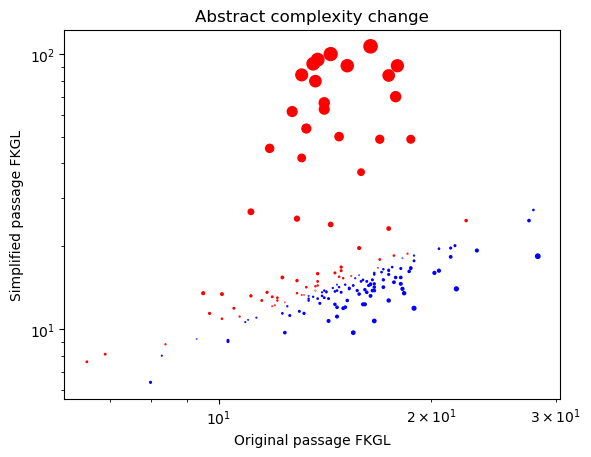

In [101]:
diff = old_fkgl_scores[:, 0] - old_fkgl_scores[:, 1]
dir = diff >= 0

plt.scatter(old_fkgl_scores[:, 0], old_fkgl_scores[:, 1], abs(diff), np.where(dir, "b", "r"))
plt.title("Abstract complexity change")
plt.xlabel("Original passage FKGL")
plt.ylabel("Simplified passage FKGL")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [76]:
outliers = []
for passage_set, scores in zip(old_simplifications["iterative"][1], old_fkgl_scores):
    if scores[0] - scores[1] < -20:
        outliers.append((passage_set, scores))

In [77]:
pprint.pprint(outliers)

[({'prediction': 'This paper proposes a wireless system for monitoring '
                 'patients that uses an ECG signal transmitter, GPS device, '
                 'and mobile phone to collect health data and send it to a '
                 'local server using Bluetooth technology Four types of '
                 'monitor units were specially designed for wireless '
                 'communication including a control center a local monitor '
                 'unit mobile devices personal digital assistant PDA and a web '
                 'page for both patients and doctors These various monitor '
                 'units are created to meet different medical personnel '
                 'requirements and preferences This application was developed '
                 'to enhance mobility and flexibility for both patients and '
                 'medical personnel ultimately improving the quality of '
                 'healthcare and the lifestyle of patients',
   'reference': 'This pap

In [ ]:
metrics = compute_metrics(
    [dataset["train"]["sentence"]["source"][0]["source_snt"]],
    ["Currently the main research topic is self-driving cars"],
    [dataset["train"]["sentence"]["reference"][0]["simplified_snt"]],
)

In [ ]:
metrics

In [ ]:
readability.Readability(dataset["train"]["abstract"]["source"][0]["source_abs"]).flesch_kincaid().score

In [22]:
# def temp_simplify_passages(name, algorithm_fn, system_prompt, parameters, passage_type, max_iter, n=None):
#     if passage_type == "abstract":
#         sources, references = get_sources_and_references("abs", n)
#     elif passage_type == "sentence":
#         sources, references = get_sources_and_references("snt", n)
#     else:
#         raise ValueError('Passage type should be "abstract" or "sentence"')

#     predictions = []
#     results = []
    
#     for i in range(len(sources)):
#         chat_bot = ChatBot(
#             model=openai_model,
#             api_key=api_key,
#         )

#         # prediction = simplify_passage_iteratively(chat_bot, system_prompt, sources[i], parameters, max_iter)
#         prediction = algorithm_fn(chat_bot, system_prompt, parameters, sources[i], max_iter)
#         # metrics = compute_metrics([sources[i]], [prediction], [references[i]])

#         predictions.append(prediction)
#         results.append({
#             "source": sources[i],
#             "prediction": prediction,
#             "reference": references[i],
#             # "metrics": metrics,
#         })

#         if ((i+1) % 100 == 0) or (i == len(sources) - 1):
#             current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
#             with open(f"./evaluations/separated_runs/{name}_i={i}_{passage_type}s_university_medium_max20_{current_datetime}", "w") as file:
#                 json.dump(results, file)

#     overall_metrics = compute_metrics(sources, predictions, references)
#     return (overall_metrics, results)

In [23]:
# passages_to_simplify = None
# passage_type_to_simplify = "sentence"

# algorithm_results["iterative"] = temp_simplify_passages("iterative", simplify_passage_iteratively, system_prompt, algorithm_parameters, passage_type_to_simplify, 20, passages_to_simplify)
# # algorithm_results["non_iterative"] = temp_simplify_passages("non_iterative", simplify_passage_iteratively, non_iterative_system_prompt, algorithm_parameters, passage_type_to_simplify, 0, passages_to_simplify)
# # algorithm_results["aiir_mistral_prompt"] = temp_simplify_passages("aiir_mistral_prompt", simplify_passage_iteratively, aiir_mistral_system_prompt, {}, passage_type_to_simplify, 0, passages_to_simplify)
# # algorithm_results["aiir_llama_run_1_prompt"] = temp_simplify_passages("aiir_llama_run_1_prompt", simplify_passage_iteratively, aiir_llama_run_1_system_prompt, {}, passage_type_to_simplify, 0, passages_to_simplify)

InternalServerError: Error code: 500 - {'error': {'message': 'Timed out generating response. Please try again with a shorter prompt or with `max_tokens` set to a lower value.', 'type': 'internal_error', 'param': None, 'code': 'request_timeout'}}

In [15]:
abs_sources, abs_references = get_sources_and_references("abs", None)
snt_sources, snt_references = get_sources_and_references("snt", None)
# def compute_metrics(sources, predictions, references):

In [16]:
compute_metrics(abs_sources, abs_references, abs_references)

{'SARI': 98.16580880548057, 'BLEU': 1.0, 'FKGL': 12.744}

In [17]:
compute_metrics(snt_sources, snt_references, snt_references)

{'SARI': 99.25864604997614, 'BLEU': 1.0, 'FKGL': 12.735073068893529}

In [18]:
compute_metrics(abs_sources, abs_sources, abs_references)

{'SARI': 50.49238528976586,
 'BLEU': 0.39948559937266054,
 'FKGL': 15.152000000000003}

In [19]:
compute_metrics(snt_sources, snt_sources, snt_references)

{'SARI': 53.69591183223906,
 'BLEU': 0.3798082685410127,
 'FKGL': 15.026096033402922}

## Graphs

In [ ]:
def my_exp(x, k, a):
    return a * (np.exp(-k * (x-0.8)) - 1)

# Define the range of x values
x = np.linspace(0, 1, 500)

# Define the functions
exp_1 = my_exp(x, k=1, a=0.816)
exp_2 = my_exp(x, k=2, a=0.253)
exp_3 = my_exp(x, k=10, a=0.00033559)
linear = 1 - 1.25 * x

nullifier = np.where(x > 0.8, 0, 1)

# Horizontal and vertical constants
horizontal_constant = 0.25
vertical_constant = 0.5

plt.figure(figsize=(10, 6))

# Functions
plt.plot(x, linear * nullifier, color="red")
plt.plot(x, exp_1 * nullifier, color="red")
plt.plot(x, exp_2 * nullifier, color="red")
plt.plot(x, exp_3 * nullifier, color="red")

# Parameters
plt.axhline(y=horizontal_constant, color="blue", linestyle="--")
plt.axvline(x=vertical_constant, color="blue", linestyle="--")
plt.fill_between(x, horizontal_constant, 1, color="blue", alpha=0.4)

# Customize the plot
plt.title("Complexity and Information Loss Trade-Off with Parameters")
plt.xlabel("Complexity")
plt.ylabel("Information loss")
plt.axhline(0, color="black", linewidth=0.5, linestyle="-")  # x-axis
plt.axvline(0, color="black", linewidth=0.5, linestyle="-")  # y-axis
plt.grid(True, linestyle="--", alpha=0.7)


plt.show()
# plt.savefig("graphs/trade_off_parameters.pdf")